<b>

<p>
<center>
<font size="5">
Capstone Project
</font>
</center>
</p>

<p>
<center>
<font size="4">
US visa Application Report
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size="3">
Author: Limin Tan, Jingshu Song
</font>
</center>
</p>

</b>

# Introduction
<br>
- As we all know, if foreigners want to work in US legally, employers must apply visa for them and it will take more than six months. However, the government will refuse the application sometimes. Both employees and employers waste a lot of time and money. Therefore, we would like to create model to solve this problem.
<br>
- Data is from kaggle(https://www.kaggle.com/jboysen/us-perm-visas). We want to create a model to predict visa application decision based on the employee and employer information and figure out which features contribute most to the decision. So for this dataset, the target feature is application status(1 is certified and 0 is deny). Obviously, this is a classification problem.

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm

# Load data

In [23]:
usPermVisas=pd.read_csv("us_perm_visas.csv",low_memory=False,na_values = ["None"])

In [24]:
#sum the type of our target
for value in usPermVisas.case_status.unique():
    print(len(usPermVisas[usPermVisas['case_status'] == value])," occurrences of status '{}'".format(value))

181933  occurrences of status 'Certified'
25649  occurrences of status 'Denied'
148586  occurrences of status 'Certified-Expired'
18194  occurrences of status 'Withdrawn'


In [25]:
#remove'withdrawn' from the appliciation status
usPermVisas = usPermVisas[usPermVisas.case_status != 'Withdrawn']

#Combining certified-expired and certified applications and displaying distribution of "case_status" variable
usPermVisas.loc[usPermVisas.case_status == 'Certified-Expired', 'case_status'] = 'Certified'
usPermVisas.case_status.value_counts()

Certified    330519
Denied        25649
Name: case_status, dtype: int64

In [26]:
#feature selection
#delete the columns with more than half missing values
#for the rest columns, we select the features according to the meaning of them
data = usPermVisas.loc[:,usPermVisas.isnull().sum()/len(usPermVisas)*100 <= 50]
cols = [col for col in data.columns if 'ri' in col]
a= cols[1:]
data = data.drop(a,axis = 1)
data = data.iloc[:,5:55]
cols_remove = [col for col in data.columns if 'postal_code'in col]
data = data.drop(cols_remove,axis = 1)
cols_remove1 = [col for col in data.columns if 'foreign_worker'in col]
data = data.drop(cols_remove1,axis = 1)
data = data.drop(columns = ['employer_address_1','employer_country','employer_city','employer_phone','ji_live_in_domestic_service',
                           'job_info_work_city','job_info_work_state','preparer_info_title','pw_determ_date',
                            'pw_expire_date','pw_track_num','recr_info_employer_rec_payment','recr_info_first_ad_start',
                            'recr_info_professional_occ','employer_name',
                           'employer_decl_info_title','job_info_job_title','pw_job_title_9089'])

In [27]:
outcome_raw =data[['case_status']]
outcome = outcome_raw.case_status.apply(lambda x: 1 if x == 'Certified' else 0)

len(outcome)

356168

In [28]:
features_raw = data.drop(['case_status'], axis =1) 
len(features_raw)

356168

# Explortary Data Analysis

In [29]:
#Converting the date to contain just the year of application submission
data = usPermVisas
format_dt = '%Y-%m-%d'
data['decision_date'] = pd.to_datetime(data['decision_date'], format = format_dt)
data['year'] = data['decision_date'].dt.year
data['year'].value_counts()

2016    119920
2015     92338
2014     73881
2013     37473
2012     21954
2011     10602
Name: year, dtype: int64

[Text(0, 0.5, 'Number of Visa applicatons'),
 Text(0.5, 0, 'Visa application year'),
 Text(0.5, 1.0, 'case status situation')]

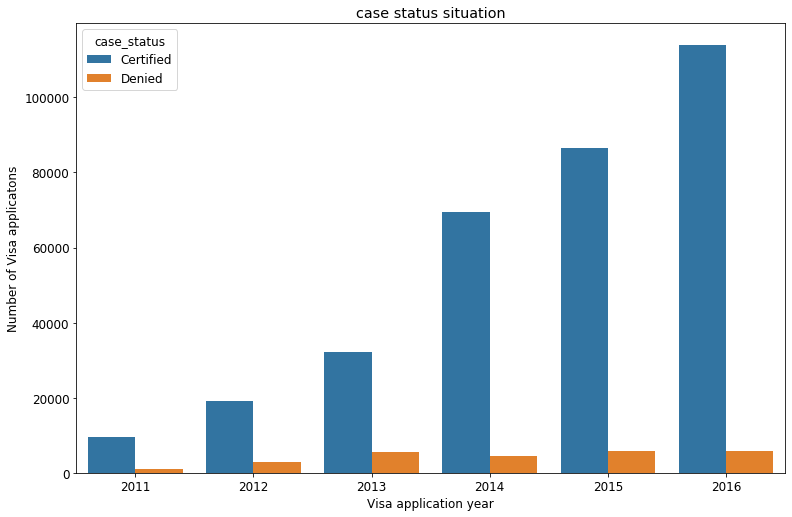

In [30]:
# case status situation
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.set_context(rc={"font.size":12})
sns.countplot(x=data['year'], hue=data["case_status"], data=data)
ax.set(xlabel='Visa application year', ylabel='Number of Visa applicatons', title = 'case status situation')

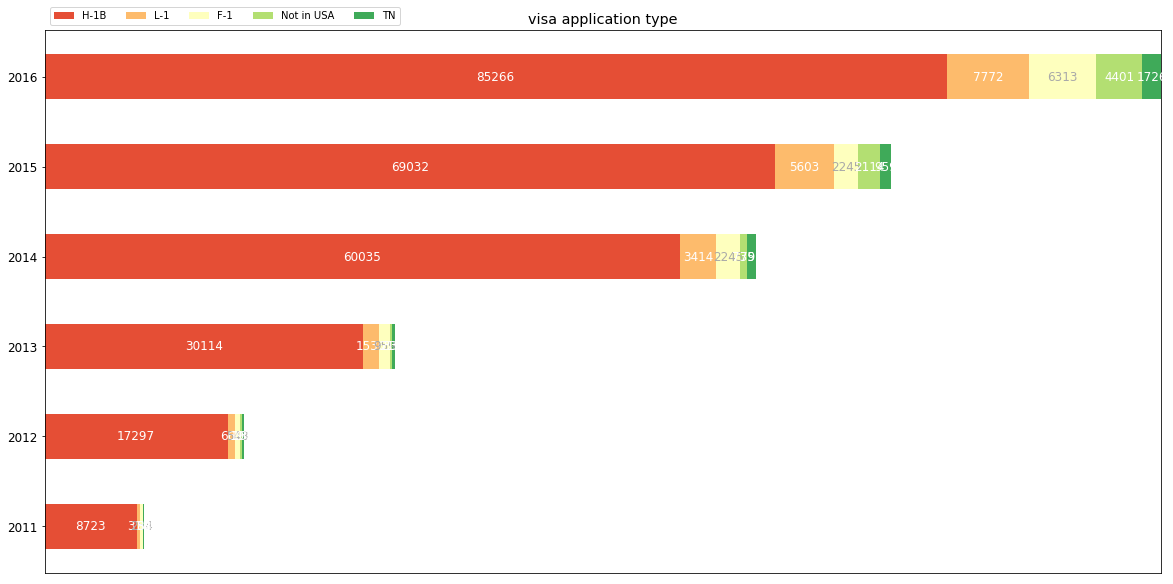

In [31]:
#application type situation
df_type = data.groupby(['year','class_of_admission']).class_of_admission.count().rename("count").reset_index()
df_type = df_type.reindex(df_type['count'].abs().sort_values(ascending=False).index)
df_type=df_type[df_type['class_of_admission'].isin(['H-1B','L-1','F-1','Not in USA','TN'])]
df_type.sort_values(by=["year"],ascending = False)

category_names = ['H-1B','L-1','F-1','Not in USA','TN']
results = {
    '2016': [85266, 7772, 6313, 4401, 1726],
    '2015': [69032, 5603, 2245, 2114, 959],
    '2014': [60035, 3414, 2245, 735, 796],
    '2013': [30114, 1536, 959, 212, 335],
    '2012': [17297, 662, 548, 197, 165],
    '2011': [8723, 314, 254, 54, 88]
}


def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    ax.set_title('visa application type')

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    return fig, ax


survey(results, category_names)
plt.show()


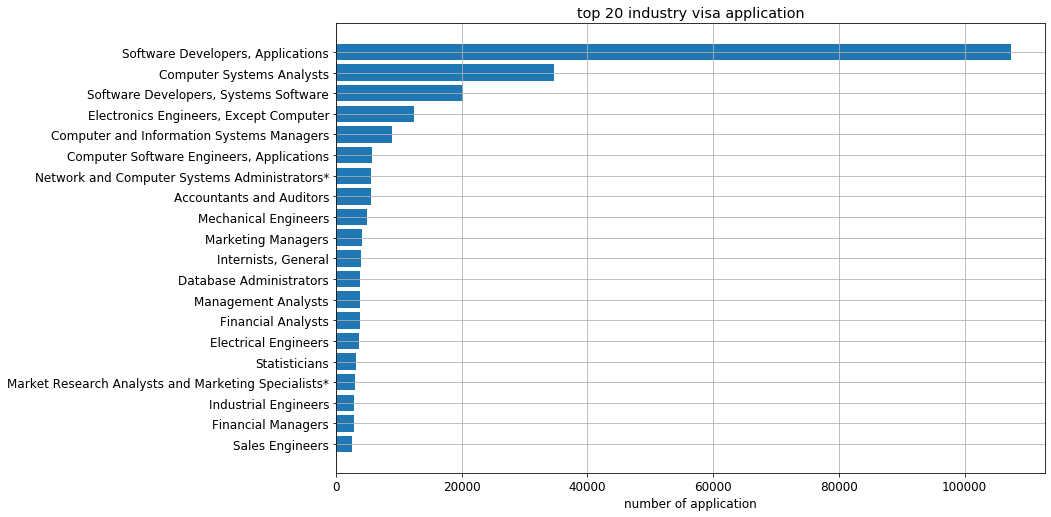

In [32]:
#top 20 industry visa application situation
df3 = data.groupby(['pw_soc_title']).class_of_admission.count().rename("count").reset_index()
df3 = df3.reindex(df3['count'].abs().sort_values(ascending=False).index).iloc[:20]

fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
ax.barh(df3['pw_soc_title'], df3['count'], align='center')
ax.set_yticks(df3['pw_soc_title'])
ax.set_yticklabels(df3['pw_soc_title'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('number of application')
ax.set_title('top 20 industry visa application')
ax.grid(True)
plt.show()

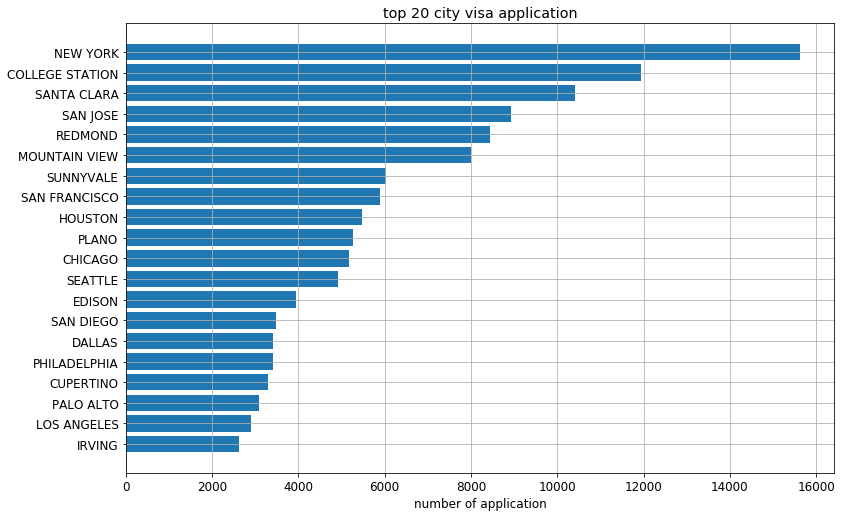

In [33]:
#top 20 cities visa application
df4 = data.groupby(['employer_city']).class_of_admission.count().rename("count").reset_index()
df4 = df4.reindex(df4['count'].abs().sort_values(ascending=False).index).iloc[:20]

fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
ax.barh(df4['employer_city'], df4['count'], align='center')
ax.set_yticks(df4['employer_city'])
ax.set_yticklabels(df4['employer_city'])
ax.invert_yaxis() # labels read top-to-bottom
ax.set_xlabel('number of application')
ax.set_title('top 20 city visa application')
ax.grid(True)
plt.show()

In [34]:
#Creating empty dictionary
us_economic_counts = {}

#Iterating over "us_economic_sector" column and appending values to the "us_economic_counts" dictionary
for value in usPermVisas['us_economic_sector'].dropna():
    if value in us_economic_counts:
        us_economic_counts[value] += 1
    else:
        us_economic_counts[value] = 1
print(us_economic_counts)

#create list for the value and key of us_economic_sector 
us_economic_value=[]
for i in us_economic_counts.values():
    us_economic_value.append(i)
print(us_economic_value)

us_economic_key=[]
for i in us_economic_counts.keys():
    us_economic_key.append(i)
print(us_economic_key)

{'IT': 49311, 'Other Economic Sector': 14662, 'Aerospace': 3917, 'Advanced Mfg': 17601, 'Educational Services': 8561, 'Retail': 4208, 'Construction': 1315, 'Hospitality': 1767, 'Automotive': 1084, 'Health Care': 6407, 'Agribusiness': 784, 'Finance': 8686, 'Energy': 1021, 'Transportation': 893, 'Homeland Security': 78, 'Biotechnology': 436, 'Geospatial': 137}
[49311, 14662, 3917, 17601, 8561, 4208, 1315, 1767, 1084, 6407, 784, 8686, 1021, 893, 78, 436, 137]
['IT', 'Other Economic Sector', 'Aerospace', 'Advanced Mfg', 'Educational Services', 'Retail', 'Construction', 'Hospitality', 'Automotive', 'Health Care', 'Agribusiness', 'Finance', 'Energy', 'Transportation', 'Homeland Security', 'Biotechnology', 'Geospatial']


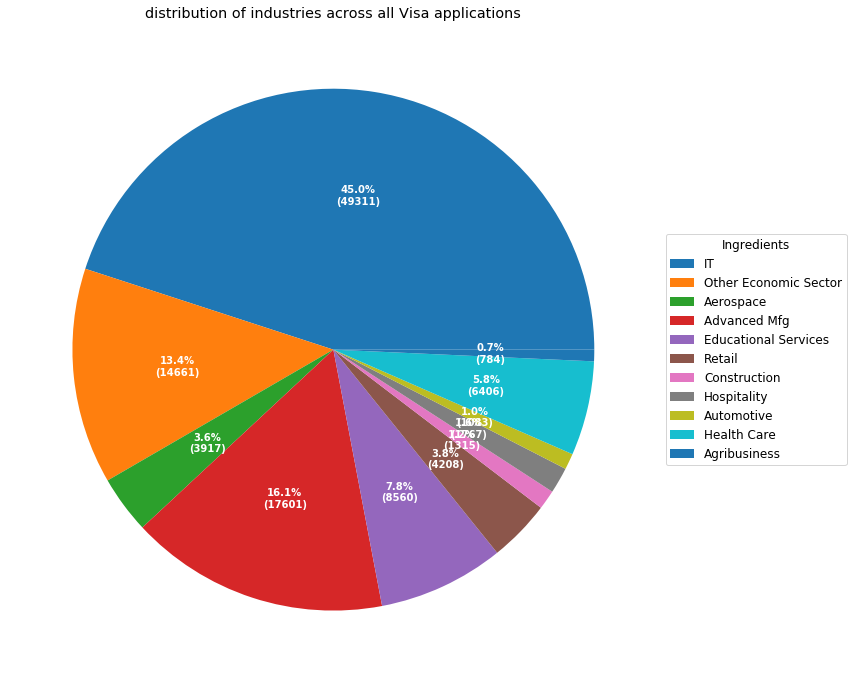

In [35]:
# Distribution of industries
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(aspect="equal"))

data = us_economic_value[0:11]
ingredients = us_economic_key[0:11]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Ingredients",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=10, weight="bold")

ax.set_title("distribution of industries across all Visa applications")

plt.show()

[Text(0, 0.5, 'Number of applications'),
 Text(0.5, 0, 'Education level'),
 Text(0.5, 1.0, 'Applicant Education level')]

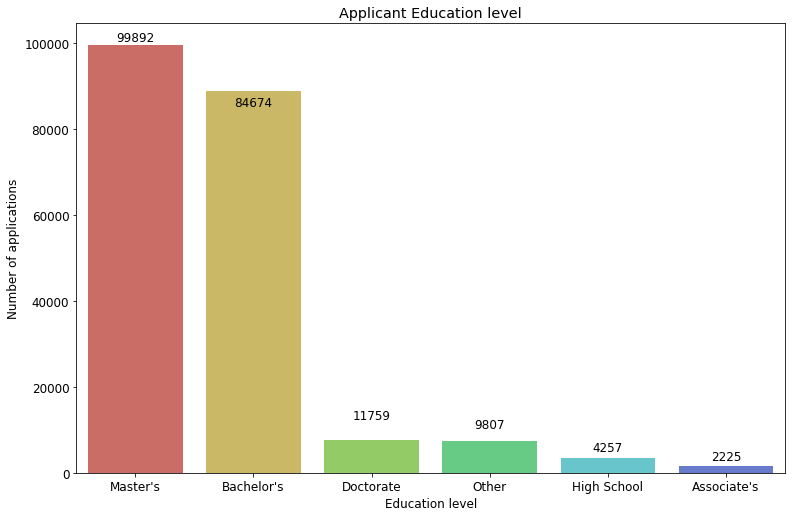

In [36]:
#Appliciant education level
#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
 #sns.set_context(rc={"font.size":14, "axes.labelsize":12})
sns.countplot(x='job_info_education',data=usPermVisas, 
               palette = sns.color_palette("hls", 8), 
               order=usPermVisas.foreign_worker_info_education.value_counts().iloc[:10].index)

#Iterating over elements in "job_info_job_title" column and displaying counts above bars 
for i, v in usPermVisas.foreign_worker_info_education.value_counts().head(10).reset_index().iterrows():
    ax.text(i,v.foreign_worker_info_education,v.unique()[1], horizontalalignment='center',verticalalignment='bottom')

#Setting label titles    
ax.set(xlabel='Education level', ylabel='Number of applications', title = 'Applicant Education level')

# Date prepocessing - deal with missing value


In [37]:
#deal with categorical data, NA means None
drop_none=['country_of_citizenship',
           'job_info_education','job_info_major',
           'job_info_alt_combo_ed_exp','job_info_alt_field','job_info_experience','job_info_foreign_ed',
           'job_info_job_req_normal',
           'pw_level_9089',
           'pw_soc_title','pw_source_name_9089']
for name in drop_none:
    features_raw[name].fillna('None',inplace=True)
    features_raw[name].astype(str)

In [38]:
# For these features, we use mode to replace NA.
drop_mode=['class_of_admission','job_info_combo_occupation','job_info_foreign_lang_req','job_info_training',
          'preparer_info_emp_completed','recr_info_coll_univ_teacher']
for name in drop_mode:
    features_raw[name].fillna(features_raw[name].mode()[0],inplace=True)
    features_raw[name].astype(str)

In [39]:
#deal with time formet
import datetime
from datetime import datetime

dt = features_raw["decision_date"]

# dt = datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')
dt = dt.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

# train["pickup_month"] = dt.month
features_raw["decision_date"] = dt.map(lambda x: x.year).astype(str)

In [40]:
#use mean to replace the missing value of number of employees
features_raw['employer_num_employees']=features_raw['employer_num_employees'].fillna((features_raw['employer_num_employees'].mean())).astype(int)

In [41]:
#deal with state column
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Northern Mariana Islands':'MP', 
    'Palau': 'PW', 
    'Puerto Rico': 'PR', 
    'Virgin Islands': 'VI', 
    'District of Columbia': 'DC'
}

#Capitalizing Keys
us_state_abbrev = {k.upper(): v for k, v in us_state_abbrev.items()}
features_raw['employer_state'].replace(us_state_abbrev, inplace=True)
features_raw.employer_state = features_raw.employer_state.astype(str)

In [42]:
features_raw = features_raw.drop(columns = ['employer_yr_estab'])

In [43]:
data1 = features_raw 

In [44]:
#deal with occuptation code
data1['pw_soc_code'] = data1['pw_soc_code'].str.replace('.','')
data1['pw_soc_code'] = data1['pw_soc_code'].str.replace('-','')
data1['pw_soc_code'] = data1['pw_soc_code'].astype(str).str[0:6]
#Finding "nan" values in "pw_soc_code" column and filling them with mode
data1.loc[data1['pw_soc_code'] == "nan",'pw_soc_code'] = data1['pw_soc_code'].mode()[0]

#Finding "None" values in "pw_soc_code" column and filling them with mode
data1.loc[data1['pw_soc_code'] == "None",'pw_soc_code'] = data1['pw_soc_code'].mode()[0]

#Changing type from string to int
data1['pw_soc_code'] = data1['pw_soc_code'].astype(int)

In [45]:
#deal with wage
data1['pw_amount_9089'] = data1['pw_amount_9089'].str.replace(",","") 
for i in data1['pw_unit_of_pay_9089'].unique():
    if i =='hr' or i == 'Hour':
        data1.loc[data1['pw_unit_of_pay_9089'] == i, 'pw_amount_9089'] = data1['pw_amount_9089'].apply(lambda x: float(x) * 8 * 250)
    elif i =='wk' or i == 'Week':
        data1.loc[data1['pw_unit_of_pay_9089'] == i, 'pw_amount_9089'] = data1['pw_amount_9089'].apply(lambda x: float(x) * 50)
    elif i == 'bi' or i == 'Bi-Weekly':
        data1.loc[data1['pw_unit_of_pay_9089'] == i, 'pw_amount_9089'] = data1['pw_amount_9089'].apply(lambda x: float(x) * 25)
    elif i == 'mth' or i =='Month':
        data1.loc[data1['pw_unit_of_pay_9089'] == i, 'pw_amount_9089'] = data1['pw_amount_9089'].apply(lambda x: float(x) * 12)
    else:
        continue

#fill na with median
data1['pw_amount_9089'] = data1['pw_amount_9089'].fillna(data1['pw_amount_9089'].median())
data1['pw_amount_9089'] = data1['pw_amount_9089'].astype(float)
data1 = data1.drop(columns = ['pw_unit_of_pay_9089'])

In [46]:
features_raw= data1

In [47]:
features_raw.sample(10)

,class_of_admission,country_of_citizenship,decision_date,employer_num_employees,employer_state,job_info_alt_combo_ed_exp,job_info_alt_field,job_info_combo_occupation,job_info_education,job_info_experience,...,job_info_job_req_normal,job_info_major,job_info_training,preparer_info_emp_completed,pw_amount_9089,pw_level_9089,pw_soc_code,pw_soc_title,pw_source_name_9089,recr_info_coll_univ_teacher
48602,H-1B,UNITED STATES OF AMERICA,2013,22348,GA,None,None,N,None,None,...,None,None,N,N,42680.00,Level I,251042,"Biological Science Teachers, Postsecondary",OES,N
128782,H-1B,CHINA,2014,22348,NY,None,None,N,None,None,...,None,None,N,N,81349.00,Level IV,132011,Accountants and Auditors,OES,N
335906,H-1B,FRANCE,2016,3826,CA,Y,N,N,Master's,Y,...,Y,"Computer Science, Engineering, Computer Engine...",N,N,96866.00,Level II,151132,"Software Developers, Applications",OES,N
285404,F-1,INDIA,2016,46544,CA,N,N,N,Master's,N,...,Y,Elect &/or Elec &/or Comp Eng &/or Sci or rela...,N,N,81453.00,Level II,172072,"Electronics Engineers, Except Computer",OES,N
13971,H-1B,None,2011,22348,SC,None,None,N,None,None,...,None,None,N,N,45000.00,Level I,251125,"History Teachers, Postsecondary",OES,N
156773,H-1B,INDIA,2015,2220,MA,Y,Y,N,Master's,N,...,Y,Computer Science,N,N,83762.00,Level II,151132,"Software Developers, Applications",OES,N
123004,H-1B,INDIA,2014,22348,CA,None,None,N,None,None,...,None,None,N,N,50.84,None,151133,"Software Developers, Systems Software",Other,N
219882,H-1B,INDIA,2015,2500,TX,N,N,N,Bachelor's,Y,...,N,"CIS, Electronic Engineering, closely related",N,N,110406.00,Level IV,151132,"Software Developers, Applications",OES,N
311549,H-1B,CHINA,2016,4,MA,N,N,N,Bachelor's,Y,...,Y,Business Administration or Economics,N,N,107515.00,Level II,111021,General and Operations Managers,OES,N
28833,H-1B,INDIA,2013,22348,NJ,None,None,N,None,None,...,None,None,N,N,101629.00,Level III,151132,"Software Developers, Applications",OES,N


# Reduce the level of category features

In [48]:
# sum the number of unique value for faetures
data_columns = ['class_of_admission', 'country_of_citizenship', 'decision_date','employer_num_employees','employer_state',
                'job_info_alt_combo_ed_exp', 'job_info_alt_field', 'job_info_combo_occupation', 'job_info_education', 
                'job_info_experience', 'job_info_foreign_ed', 'job_info_foreign_lang_req', 'job_info_job_req_normal',
                'job_info_major',
                'job_info_training', 'preparer_info_emp_completed','pw_amount_9089', 'pw_level_9089', 'pw_soc_code', 
                'pw_soc_title','pw_source_name_9089',
                'recr_info_coll_univ_teacher']
for i in data_columns:
    print(i,':',features_raw[i].nunique())

class_of_admission : 57
country_of_citizenship : 202
decision_date : 6
employer_num_employees : 4532
employer_state : 60
job_info_alt_combo_ed_exp : 3
job_info_alt_field : 3
job_info_combo_occupation : 2
job_info_education : 7
job_info_experience : 3
job_info_foreign_ed : 3
job_info_foreign_lang_req : 2
job_info_job_req_normal : 3
job_info_major : 51915
job_info_training : 2
preparer_info_emp_completed : 2
pw_amount_9089 : 24037
pw_level_9089 : 5
pw_soc_code : 769
pw_soc_title : 899
pw_source_name_9089 : 7
recr_info_coll_univ_teacher : 2


In [49]:
#use other to replace the values which has a very low frequency
column_list=['country_of_citizenship','job_info_major' ,'pw_soc_code', 'pw_soc_title']

for i in  column_list:    
    series = pd.value_counts(features_raw[i])    
    mask = (series/series.sum() * 1000).lt(0.5)
    features_raw[i] = np.where(features_raw[i].isin(series[mask].index),'Other',features_raw[i])

In [50]:
#after prorpocessing, sum the number of unique values 
data_columns = ['class_of_admission', 'country_of_citizenship', 'decision_date','employer_num_employees','employer_state',
                'job_info_alt_combo_ed_exp', 'job_info_alt_field', 'job_info_combo_occupation', 'job_info_education', 
                'job_info_experience', 'job_info_foreign_ed', 'job_info_foreign_lang_req', 'job_info_job_req_normal',
                'job_info_major',
                'job_info_training', 'preparer_info_emp_completed','pw_amount_9089','pw_level_9089', 'pw_soc_code', 
                'pw_soc_title','pw_source_name_9089',
                'recr_info_coll_univ_teacher']
for i in data_columns:
    print(i,':',features_raw[i].nunique())

class_of_admission : 57
country_of_citizenship : 74
decision_date : 6
employer_num_employees : 4532
employer_state : 60
job_info_alt_combo_ed_exp : 3
job_info_alt_field : 3
job_info_combo_occupation : 2
job_info_education : 7
job_info_experience : 3
job_info_foreign_ed : 3
job_info_foreign_lang_req : 2
job_info_job_req_normal : 3
job_info_major : 100
job_info_training : 2
preparer_info_emp_completed : 2
pw_amount_9089 : 24037
pw_level_9089 : 5
pw_soc_code : 166
pw_soc_title : 161
pw_source_name_9089 : 7
recr_info_coll_univ_teacher : 2


# Encoding and scaling

In [51]:
#endcode the feature the still have too many category
from category_encoders.cat_boost import CatBoostEncoder
CBE_encoder = CatBoostEncoder()
#features_raw['employer_postal_code']=train_cbe = CBE_encoder.fit_transform(features_raw[['employer_postal_code']], outcome)
features_raw['pw_soc_code']=train_cbe = CBE_encoder.fit_transform(features_raw[['pw_soc_code']], outcome)

In [52]:
#encode the feature that have limited number of category
features_raw=pd.get_dummies(features_raw, columns=['class_of_admission', 'country_of_citizenship','decision_date','employer_state',
                                                   'job_info_alt_combo_ed_exp','job_info_alt_field','job_info_combo_occupation',
                                                   'job_info_education','job_info_experience','job_info_foreign_ed','job_info_foreign_lang_req',
                                                   'job_info_job_req_normal','job_info_major',
                                                   'job_info_training','preparer_info_emp_completed',
                                                   'pw_level_9089','pw_soc_title','pw_source_name_9089',
                                                   'recr_info_coll_univ_teacher'])


In [53]:
# Scaling of all numerical data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features_raw = scaler.fit_transform(features_raw)

# Split training and testing 

In [54]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(features_raw, outcome, test_size=0.2, random_state=11)

print("Training and testing split was successful.")
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training and testing split was successful.
Training set has 284934 samples.
Testing set has 71234 samples.


# Oversampling 

In [39]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

#sampler = RandomOverSampler(random_state=0)
sampler = SMOTE() #Oversampling to generate new samples
X_resampled,Y_resampled = sampler.fit_sample(X_train,y_train)
print(X_resampled.shape,Y_resampled.shape)

(528578, 505) (528578,)


# Build the model

In [54]:
#evaluate the performance of the model

from sklearn.metrics import accuracy_score, fbeta_score, f1_score, precision_score, recall_score
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: outcome training set
       - X_test: features testing set
       - y_test: outcome testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() 
    learner = learner.fit(X_train, y_train)
    
    end = time() 
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set & on the first 10% of the training samples - X_train[:239831]
    start = time() 
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train)
    end = time()
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    # Compute precision on the training samples
    results['precision_train'] = precision_score(y_train, predictions_train, average='weighted')
    
    # Compute precision on test set
    results['precision_test'] = precision_score(y_test, predictions_test, average='weighted')
    
    # Compute F-score on the training samples
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.5, average='weighted')
    
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5, average='weighted')

    # Print all
    print("Training {}".format(learner.__class__.__name__))
    print("Precision result {}".format(results['precision_test'], learner.__class__.__name__))
    print("F-score result {}".format(results['f_test'], learner.__class__.__name__))
    print("Recall result {}".format(recall_score(y_test, predictions_test, average='weighted'), learner.__class__.__name__))

    # Return the results
    return results
    
print('Done')

Done


# Model Evaluation

In [55]:
#Initial Model Evaluation: Import the supervised learning models from sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

from time import time
time0 = time()

# Initialize the three models
clf_A = LogisticRegression(penalty='l2', random_state=24)
clf_B = RandomForestClassifier(n_estimators=10, random_state=16)
clf_C = ExtraTreesClassifier()
clf_D = DecisionTreeClassifier(random_state=41)
# Collect results on the learners
results = {}

for clf in [clf_A, clf_B,clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

# Show processing time in h:m:s
m, s = divmod(time()-time0, 60)
h, m = divmod(m, 60)
print("Time elapsed: %d:%02d:%02d\n" % (h, m, s))

C:\Users\kenny\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training LogisticRegression
Precision result 0.9246534992707613
F-score result 0.9121302712035552
Recall result 0.9363365808462251
Training RandomForestClassifier
Precision result 0.9335553578755285
F-score result 0.9334086719594701
Recall result 0.9422326417160345
Training ExtraTreesClassifier
Precision result 0.931493108558461
F-score result 0.9315635604847358
Recall result 0.9405901676165875
Training DecisionTreeClassifier
Precision result 0.9200728430792654
F-score result 0.9199464235607175
Recall result 0.9194485779262712
Time elapsed: 0:06:36



# Hyperparameter tunning

In [46]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 300, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap':bootstrap}
print(random_grid)

{'n_estimators': [200, 207, 214, 221, 228, 235, 242, 250, 257, 264, 271, 278, 285, 292, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 50,
                               cv = 3,
                               verbose = 1,
                               random_state = 42,
                               n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 75.5min


In [51]:
# Get the best parameters
rf_random.best_params_

{'n_estimators': 292,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
# Get the best parameters
best_grid = rf_random.best_estimator_

# Predictions
y_pred = best_grid.predict(X_test)

#Create a dataframe with the confusion matrix
cm_df = pd.DataFrame(confusion_matrix(y_test, y_pred),
                            columns=['Predicted_0','Predicted_1'],
                            index = ['Actual_0','Actual_1'])

print('---------- confusion matrix ------------')
print(cm_df)
print('---------- accuracy ------------')
print(accuracy_score(y_pred, y_test))
print('---------- classification report ------------')
print(classification_report(y_test,y_pred,digits = 3))

# Feature Importance

In [53]:
importances = best_grid.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature: %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature: pw_soc_code (0.204113)
2. feature: pw_amount_9089 (0.106554)
3. feature: pw_soc_title_None (0.050660)
4. feature: employer_num_employees (0.043395)
5. feature: pw_source_name_9089_None (0.039527)
6. feature: pw_level_9089_None (0.011076)
7. feature: pw_source_name_9089_OES (0.010476)
8. feature: pw_soc_title_Computer Systems Analysts (0.009429)
9. feature: decision_date_2014 (0.009288)
10. feature: pw_soc_title_Other (0.008933)
11. feature: country_of_citizenship_INDIA (0.008855)
12. feature: pw_source_name_9089_Other (0.008122)
13. feature: employer_state_TX (0.008001)
14. feature: class_of_admission_H-1B (0.007502)
15. feature: job_info_major_None (0.007251)
16. feature: pw_level_9089_Level I (0.007148)
17. feature: pw_soc_title_Computer Software Engineers, Applications (0.007067)
18. feature: decision_date_2013 (0.007057)
19. feature: employer_state_CA (0.006893)
20. feature: pw_soc_title_Software Developers, Applications (0.006653)
21. feature: pw_level